In [2]:
import lightning

from model import GiBERTino

model = GiBERTino.load_from_checkpoint("alibaba-modernbert-molweni-epoch-epoch=08-val_loss=2.49.ckpt")
model

2025-03-31 09:58:17,865 - INFO - Use pytorch device_name: cpu
2025-03-31 09:58:17,870 - INFO - Load pretrained SentenceTransformer: Alibaba-NLP/gte-modernbert-base


GiBERTino(
  (gnn_model): GCN(41, 50, num_layers=3)
  (bert_model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=Fal

In [6]:
from dataset.dialogue_graph_datamodule import SubDialogueDataModule

model.eval()
data_module = SubDialogueDataModule("data/MOLWENI/alibaba-graphs", "MOLWENI", num_workers=0)
data_module.setup(stage="test")
test_loader = data_module.test_dataloader()
test_loader

In [12]:
import torch 
from tqdm import tqdm

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Processing test data"):
        link_logits, rel_probs = model(batch)

        link_labels = batch[('edu', 'to', 'edu')].get('link_labels', None)
        rel_labels = batch[('edu', 'to', 'edu')].get('rel_labels', None)

        print(link_labels.shape)
        break


Processing test data:   0%|          | 0/23 [00:14<?, ?it/s]

torch.Size([357])


In [ ]:
edge_index = batch["edu", "to", "edu"].edge_index
edge_index.T

In [ ]:
batch.to_data_list()

In [19]:
edge_index = batch.to_data_list()[0]["edu", "to", "edu"].edge_index.T
link_labels = batch.to_data_list()[0]["edu", "to", "edu"].link_labels
rel_labels = batch.to_data_list()[0]["edu", "to", "edu"].rel_labels

In [20]:
edge_index_tmp = edge_index[link_labels == 1]
edge_index_tmp

tensor([[0, 1],
        [1, 2],
        [2, 3],
        [6, 8],
        [3, 4],
        [6, 7],
        [4, 5],
        [5, 6]])

In [32]:
import os
import random
from itertools import permutations

import numpy as np
import torch
from torch_geometric.data import InMemoryDataset, HeteroData

from utils import get_device
from utils.constants import NEGATIVE_SAMPLES_RATIO, RELATIONS


def encode_relation_type(edge_type: str) -> int:  # noqa
    relations = ["QAP",
                "Comment",
                "Clarification_question",
                "Continuation",
                "Acknowledgement",
                "Conditional",
                "Contrast",
                "Explanation",
                "Elaboration",
                "Result",
                "Correction",
                "Q-Elab",
                "Parallel",
                "Background",
                "Alternation",
                "Narration"]
    if edge_type not in relations:
        raise ValueError(f"Unknown relation type: {edge_type}")
    return relations.index(edge_type)

graph = torch.load("data/MOLWENI/alibaba-graphs/train/1.pt", map_location=torch.device("cpu"),
                   weights_only=False)

# collect positive edges
pos_edges = []
rel_labels = []
for edge_type in graph.edge_types:
    graph_edge_index = graph[edge_type[1]].edge_index
    pos_edges.extend(graph_edge_index.t().tolist())
    rel_labels.extend([encode_relation_type(edge_type[1])] * graph_edge_index.shape[1])

# generate all possible edges and sample negative edges
num_nodes = graph["edu"].x.shape[0]
all_possible_edges = list(permutations(range(num_nodes), 2))
neg_edges = [edge for edge in all_possible_edges if edge not in pos_edges]

num_negatives = int(len(pos_edges) * 0.1 / 100)
neg_edges = random.sample(neg_edges, num_negatives)

# combine positive and negative edges
edges = np.array(pos_edges + neg_edges)
edge_index = torch.tensor(edges, dtype=torch.long).T
# label: 1 for pos, 0 for neg
link_labels = torch.tensor(np.array([1] * len(pos_edges) + [0] * len(neg_edges)), dtype=torch.long)
# label: [0-11] for pos, 12 for neg
rel_labels = torch.tensor(np.array(rel_labels + [15] * len(neg_edges)), dtype=torch.long)

new_graph = HeteroData()
new_graph["edu"].x = graph["edu"].x
new_graph["edu"].edus = graph["edu"].edus
# Structural edges (edges that define the graph)
new_graph["edu", "to", "edu"].edge_index = edge_index

# Training edges (link prediction task)
new_graph["edu", "to", "edu"].link_labels = link_labels
new_graph["edu", "to", "edu"].rel_labels = rel_labels
new_graph

HeteroData(
  edu={
    x=[7, 2],
    edus={
      input_ids=[7, 39],
      attention_mask=[7, 39],
    },
  },
  (edu, to, edu)={
    edge_index=[2, 6],
    link_labels=[6],
    rel_labels=[6],
  }
)

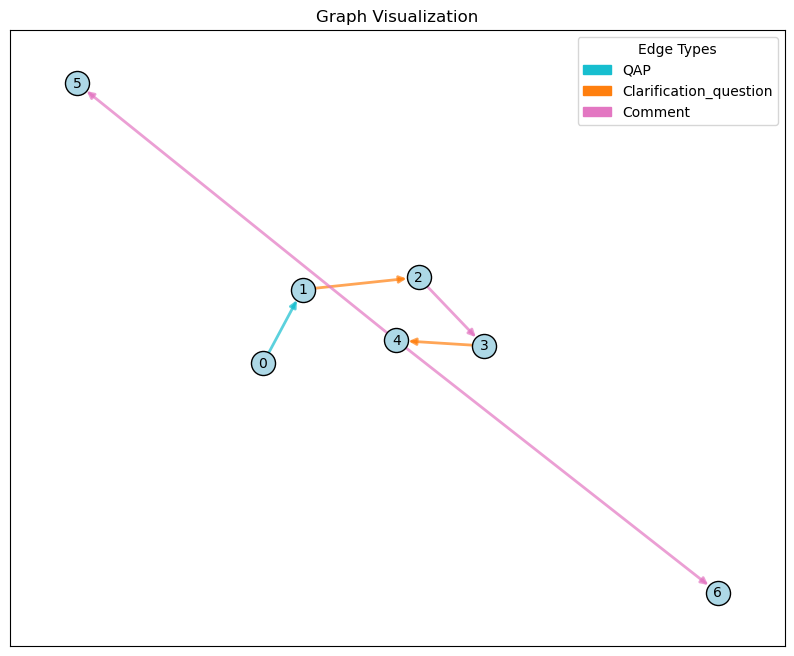

In [36]:
from utils import display_graph

display_graph(graph)